In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

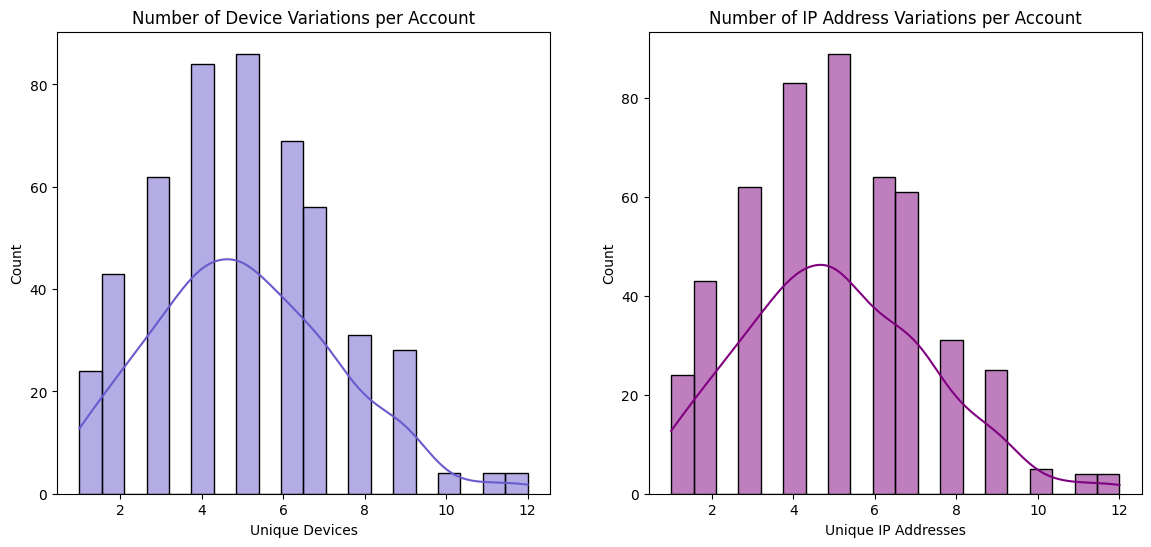

In [2]:
df=pd.read_csv('dataset/bank_transactions_data_2.csv')
# Cell 2: Plotting Device and IP Address Variations
device_variations = df.groupby('AccountID')['DeviceID'].nunique()
ip_variations = df.groupby('AccountID')['IP Address'].nunique()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(device_variations, bins=20, color='slateblue', kde=True)
plt.title("Number of Device Variations per Account")
plt.xlabel("Unique Devices")

plt.subplot(1, 2, 2)
sns.histplot(ip_variations, bins=20, color='purple', kde=True)
plt.title("Number of IP Address Variations per Account")
plt.xlabel("Unique IP Addresses")
plt.show()

In [3]:
X = df[['TransactionAmount', 'CustomerAge']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-means Clustering
### Purpose:
 Divides data into k clusters by minimizing the variance within clusters. Each point is assigned to the nearest cluster center.
 ### How it works: 
 After clustering, the distance of each point to its cluster centroid is computed. Points far from the centroid can be flagged as anomalies, as they deviate significantly from the cluster's "average" behavior.
 ### Anomaly Detection:
  Outliers can be identified by setting a threshold (e.g., top 5% of farthest points from centroids) to flag potential anomalies.

In [4]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate distances from cluster centroids
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Define threshold for potential frauds (top 5%)
threshold = np.percentile(distances, 95)
fraud_flags = distances > threshold

# Add labels to the dataframe
df['KMeans_Cluster'] = kmeans_labels
df['Potential_Fraud'] = fraud_flags


/Users/manasarthak/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


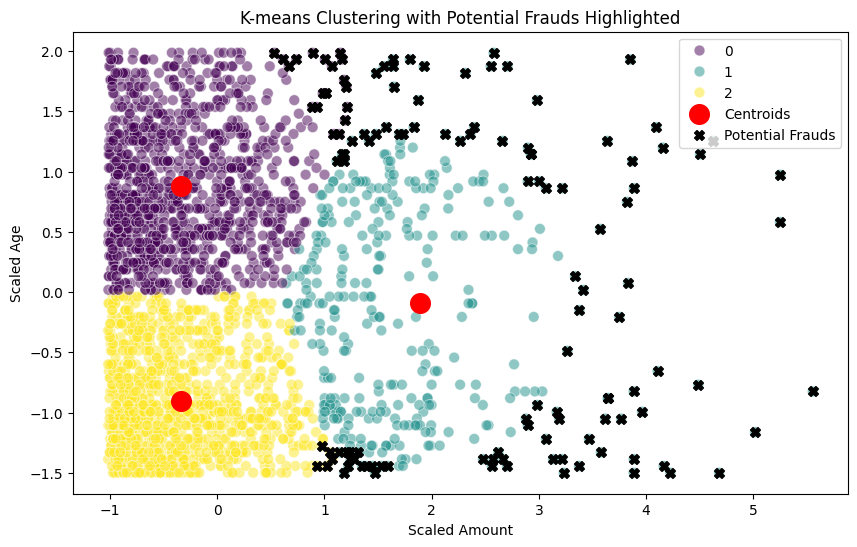

In [5]:
# Cell 5: Visualize K-means Clustering with Potential Frauds Highlighted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=60, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.scatter(X_scaled[fraud_flags, 0], X_scaled[fraud_flags, 1], color='black', s=50, label='Potential Frauds', marker='X')
plt.title('K-means Clustering with Potential Frauds Highlighted')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend()
plt.show()


## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
### Purpose:
 Clusters based on data density, creating clusters in high-density regions and marking low-density points as "noise."
### How it works: 
DBSCAN requires two parameters—eps (maximum distance between points) and min_samples (minimum points for a dense region). Points not belonging to any dense region (labeled -1) are marked as anomalies.
### Anomaly Detection: 
Points labeled as noise are potential anomalies, as they don’t fit into any dense cluster.

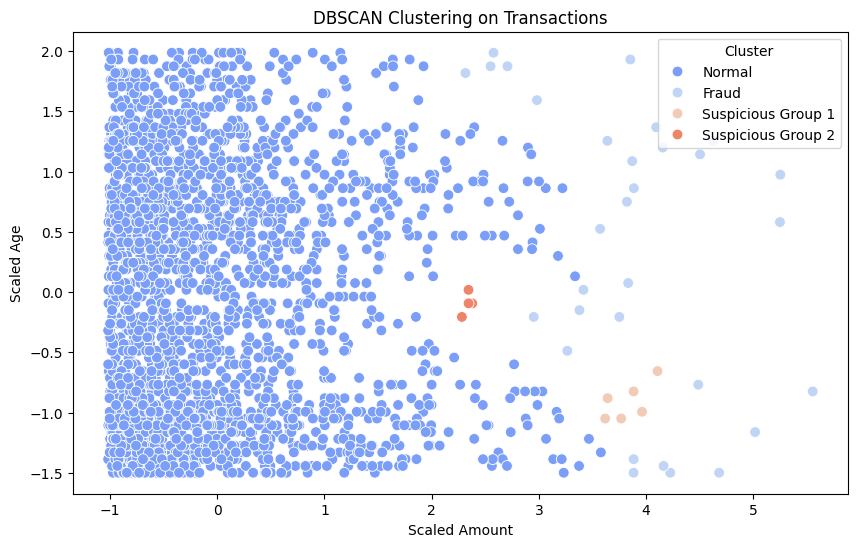

In [11]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = dbscan_labels
# Map the cluster labels to descriptive names
label_mapping = {-1: 'Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].map(label_mapping)

# Plotting with updated labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['DBSCAN_Cluster'], palette='coolwarm', s=60)
plt.title('DBSCAN Clustering on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()

## Hierarchical Clustering
### Purpose: 
Creates a tree-like structure of clusters by successively merging or splitting clusters based on distances.
### How it works:
 Hierarchical clustering is often used to observe the overall structure and relationships between data clusters. Outliers can appear as isolated points or form small clusters separate from the main groups.
### Anomaly Detection: 
Outliers may appear as small clusters or single points in a hierarchical dendrogram, helping visually identify anomalies.

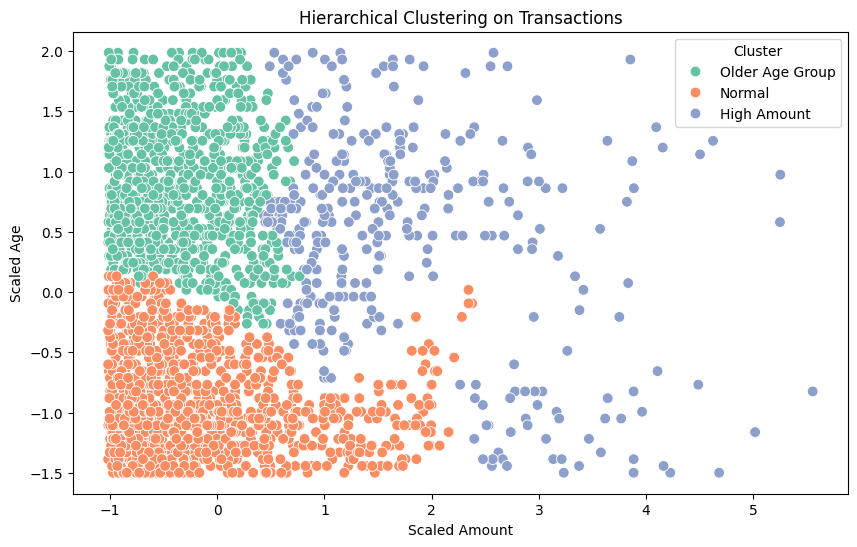

In [13]:
# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add labels to the dataset
df['Hierarchical_Cluster'] = hierarchical_labels

# Mapping the cluster labels to descriptive names
cluster_mapping = {0: 'Normal', 1: 'High Amount', 2: 'Older Age Group'}
df['Hierarchical_Cluster'] = df['Hierarchical_Cluster'].map(cluster_mapping)

# Plot with updated labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Hierarchical_Cluster'], palette='Set2', s=60)
plt.title('Hierarchical Clustering on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()

## Isolation Forest
### Purpose: 
Uses a tree-based model to isolate points in the dataset. The model isolates anomalies faster than normal points because they require fewer splits in the tree structure.
### How it works:
 Points isolated with fewer splits are considered anomalies. This method is particularly effective for detecting outliers in high-dimensional datasets.
### Anomaly Detection: 
Anomalies are flagged based on the "depth" of isolation in the tree. Points with a high anomaly score are flagged as potential outliers.

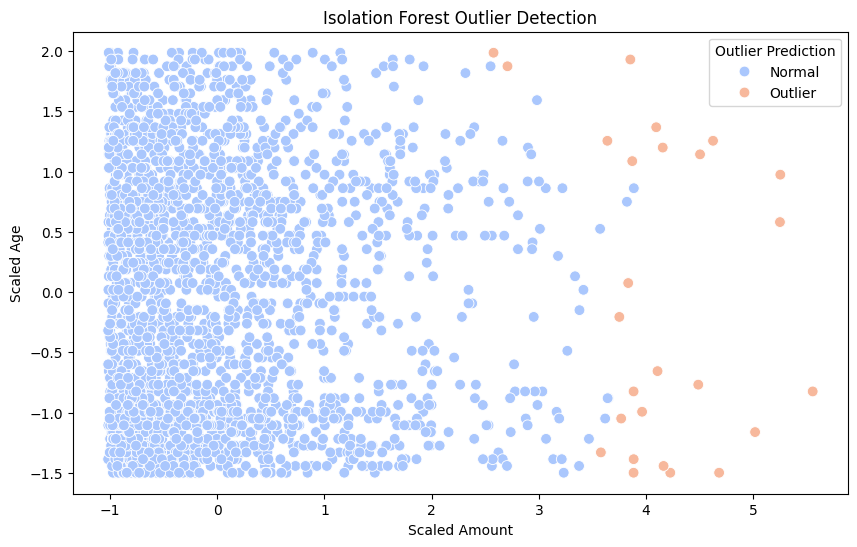

In [16]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso_forest.fit_predict(X_scaled)
df['ISO_Cluster'] = outlier_pred
# Mapping the cluster labels to descriptive names
cluster_mapping = {-1: 'Outlier', 1: 'Normal'}
df['ISO_Cluster'] = df['ISO_Cluster'].map(cluster_mapping)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['ISO_Cluster'], palette='coolwarm', s=60)
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Outlier Prediction')
plt.show()
